### titanic：哪类人会存活下来？

### 添加模块

In [139]:
import pandas as pd
import numpy as np
import re

In [140]:
# -*- coding:utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.sans-serif"] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

In [141]:
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

In [142]:
import warnings
warnings.filterwarnings("ignore")

In [143]:
import sklearn
sklearn.__version__

'0.21.3'

### 获取数据

In [144]:
gender_submission = pd.read_csv("./data/titanic/gender_submission.csv")
test = pd.read_csv("./data/titanic/test.csv")
train = pd.read_csv("./data/titanic/train.csv")

In [145]:
#gender_submission.head()

In [146]:
#test.head()

#### 表数据如下：

In [147]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 数据探索

#### 表字段信息介绍


Variable | Definition | Key
---|---|---
survival|Survival|0 = No, 1 = Yes
pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd
sex|Sex|
Age|Age in years|
sibsp|# of siblings / spouses aboard the Titanic (在船上充当什么家庭身份，平辈亲人：亲兄弟，表兄弟，丈夫、妻)|
parch|# of parents / children aboard the Titanic (在船上充当什么家庭身份，非平辈亲人：父母、儿子、孙子等)|
ticket|Ticket number|
fare|Passenger fare|
cabin|Cabin number(舱号)|
embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton


    Variable Notes
    pclass: A proxy for socio-economic status (SES)
    1st = Upper
    2nd = Middle
    3rd = Lower

    age: Age is fractional（小数） if less than 1. If the age is estimated(估计), is it in the form of xx.5

    sibsp: The dataset defines family relations in this way...
    Sibling = brother, sister, stepbrother, stepsister
    Spouse = husband, wife (mistresses and fiancés were ignored)

    parch: The dataset defines family relations in this way...
    Parent = mother, father
    Child = daughter, son, stepdaughter, stepson
    Some children travelled only with a nanny, therefore parch=0 for them.

In [148]:
df = train.copy()

In [149]:
df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Nicola-Yarred, Master. Elias",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [150]:
print("Age有空值个数：", len(df[df.Age.isna()]))

Age有空值个数： 177


In [151]:
print("Cabin有空值个数：", len(df[df.Cabin.isna()]))

Cabin有空值个数： 687


In [152]:
print("Embarked有空值个数：", len(df[df.Embarked.isna()]))

Embarked有空值个数： 2


#### 发现1 ：存在缺失值
1. 根据`df.describe().T`方法，可知`Age`有空值
2. 依据原始表数据,`Cabin`存在缺失值
3. 依`df.describe().T`方法，可知`Embarked`有空值

ps:处理这类问题，一般有：
1. 删除这部分数据
2. 填充

#### 发现2 ：存在定性特征
1. 依据原始表数据,可知`Sex`是以 `male`和`female`数据形式
2. 依据原始表数据,可知`Embarked`是以 `S`和`Q`、`C`数据形式）

ps:处理这类问题，一般有：
1. 采用哑变量方式（one-hot），进行处理，结果特征有非线性效果


#### 发现3：无量纲化
1. 依原表，Age数据以23.0, 0.9, 18.1形式
2. 依原表，Fare数据以7.2500, 71.2833, 7.9200形式

ps:处理这类问题，一般有：
1. 标准化
2. 区间缩放法
3. 归一化

#### 探索1：Cabin的缺失值很大，如何对其补全？

##### 了解一下这船上各社会经济地位的人的人数情况（Pclass-counts）

In [153]:
Pc_counts  = df.Pclass.value_counts()


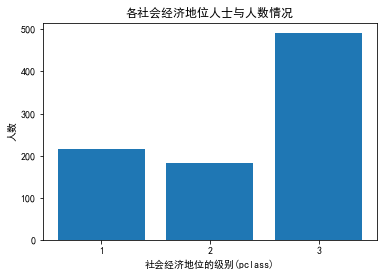

PS:
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower


In [154]:
x = Pc_counts.keys().tolist()

y = Pc_counts.values.tolist()

plt.bar(x,y, tick_label = x)
plt.title("各社会经济地位人士与人数情况")
plt.xlabel("社会经济地位的级别(pclass)")
plt.ylabel("人数")
# plt.xlabel('f')
# plt.ylabel()
plt.show()
print("""PS:
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower""")

依图所示，船上上等和中等阶层人士都大约在200人左右，而低层人士大约500人左右。

##### 了解船上乘客年龄情况

In [155]:
print("年龄Age有空值个数：", len(df[df.Age.isna()]))

年龄Age有空值个数： 177


In [156]:
age_min = df.Age.min()
age_max = df.Age.max()

In [157]:
print(f"年龄Age最小是{age_min}岁")
print(f"年龄Age最大是{age_max}岁")

年龄Age最小是0.42岁
年龄Age最大是80.0岁


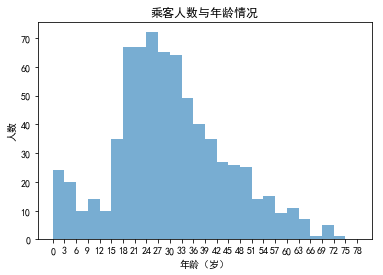

In [158]:
x = df.Age.values.tolist()
bins = range(0,80, 3)
plt.hist(x,
        bins = bins,
        histtype = "bar",
        rwidth = 2, 
        alpha = 0.6
        )
plt.xlabel("年龄（岁）")
plt.ylabel("人数")
plt.title("乘客人数与年龄情况")
plt.xticks(np.arange(0, 80, step=3))

plt.show()

Age在177个缺失值的情况下，依表所示，船上的小孩和老人占较小部分，主要是青壮年为主。

### 数据处理

#### 训练数据与测试数据合并处理

In [159]:
df_train = train.copy()
df_train["train"] = 1
df_test = test.copy()
df_test["train"] = 0

In [160]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [161]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [162]:
df = df_train.append(df_test)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,train
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1


In [163]:
print("测试数据个数为：", len(df_test))

测试数据个数为： 418


In [164]:
print("总数据集中由于加入了测试数据，所以Survived部分是null的，Survived为null的个数为：", df.Survived.isnull().sum())

总数据集中由于加入了测试数据，所以Survived部分是null的，Survived为null的个数为： 418


#### 针对测试集Fare存在缺失值
采用中位数填充

In [165]:
print("未处理前，空值有", df.Fare.isnull().sum(), "个")

未处理前，空值有 1 个


In [166]:
#### 针对Age存在缺失值
imp = SimpleImputer(missing_values=np.nan, strategy = "median")

df["Fare"]= imp.fit_transform(df.Fare.values.reshape(-1,1))

In [167]:
print("处理后，空值有", df.Fare.isnull().sum(), "个")

处理后，空值有 0 个


#### 针对Age存在缺失值
采用平均数填充

In [168]:
print("未处理前，空值有", df.Age.isnull().sum(), "个")

未处理前，空值有 263 个


In [169]:
#### 针对Age存在缺失值
imp = SimpleImputer(missing_values=np.nan, strategy = "mean")

df["Age"]= imp.fit_transform(df.Age.values.reshape(-1,1))

In [170]:
print("处理后，空值有", df.Age.isnull().sum(), "个")

处理后，空值有 0 个


#### 针对Cabin存在缺失值
将Cabin列缺失设为U0,之后将Cabin的数据拆分成两列Cabin_char和Cabin_num 

具体如：Cabin("C123 C124")分成Cabin_char("C")和Cabin_num("123")

In [171]:
print("处理前：")
df.Cabin.head()

处理前：


0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [172]:
print("Cabin列缺失设为U0")
df.Cabin[df.Cabin.isna()] = 'U0'

Cabin列缺失设为U0


In [173]:
df.Cabin.head()

0      U0
1     C85
2      U0
3    C123
4      U0
Name: Cabin, dtype: object

In [174]:
# re.findall("([A-Z]{1})([0-9]*)", "C123 A23 ")[0][1]

In [175]:
print("Cabin_char列:")

Cabin_char列:


In [176]:
enc = preprocessing.OrdinalEncoder()
df["Cabin_char"] = enc.fit_transform(df.Cabin.apply(lambda x: x[0]).values.reshape(-1, 1))

df.Cabin_char[0:5]

0    8.0
1    2.0
2    8.0
3    2.0
4    8.0
Name: Cabin_char, dtype: float64

In [177]:
print("Cabin_num列:")

df["Cabin_num"] = enc.fit_transform(df.Cabin.apply(lambda x: re.search("([A-Z]{1})([0-9]*)", x)[2]).values.reshape(-1, 1))

df.Cabin_num[0:5]

Cabin_num列:


0     1.0
1    92.0
2     1.0
3    16.0
4     1.0
Name: Cabin_num, dtype: float64

In [178]:
print("处理后：")
df.head()

处理后：


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,train,Cabin_char,Cabin_num
0,22.0,U0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,8.0,1.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,2.0,92.0
2,26.0,U0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,8.0,1.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,2.0,16.0
4,35.0,U0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,8.0,1.0


#### 针对Embarked存在缺失值
采用most_frequent填充

In [179]:
print("未处理前，空值有", df.Embarked.isnull().sum(), "个")

未处理前，空值有 2 个


In [180]:
imp = SimpleImputer(strategy="most_frequent")
df.Embarked = imp.fit_transform(df.Embarked.values.reshape(-1, 1))

In [181]:
print("处理后，空值有", df.Embarked.isnull().sum(), "个")

处理后，空值有 0 个


#### 针对Sex存在定性特征
采用ordinal处理

In [182]:
df.Age.values.reshape(-1,1)

array([[22.        ],
       [38.        ],
       [26.        ],
       ...,
       [38.5       ],
       [29.88113767],
       [29.88113767]])

In [183]:
print("未处理前:")
df.Sex.head()

未处理前:


0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [184]:
enc = preprocessing.OrdinalEncoder()
df.Sex = enc.fit_transform(df.Sex.values.reshape(-1, 1))

In [185]:
print("处理后：")
df.Sex.head()

处理后：


0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: Sex, dtype: float64

#### 针对Embarked存在定性特征
采用onehot

In [186]:
print("处理前：")
df.head()

处理前：


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,train,Cabin_char,Cabin_num
0,22.0,U0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1.0,1,0.0,A/5 21171,1,8.0,1.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0.0,1,1.0,PC 17599,1,2.0,92.0
2,26.0,U0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0.0,0,1.0,STON/O2. 3101282,1,8.0,1.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0.0,1,1.0,113803,1,2.0,16.0
4,35.0,U0,S,8.0500,"Allen, Mr. William Henry",0,5,3,1.0,0,0.0,373450,1,8.0,1.0


In [187]:
onehot = preprocessing.OneHotEncoder()
data = onehot.fit_transform(df.Embarked.values.reshape(-1,1)).toarray()

In [188]:
col_names = ["Embarked_"+onehot.categories_[0][i] for i in range(len(onehot.categories_[0]))]

In [189]:
col_names

['Embarked_C', 'Embarked_Q', 'Embarked_S']

In [190]:
for i in range(len(col_names)):
    df[col_names[i]] = data[:,i]

In [191]:
print("处理后：")
df.head()

处理后：


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,train,Cabin_char,Cabin_num,Embarked_C,Embarked_Q,Embarked_S
0,22.0,U0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1.0,1,0.0,A/5 21171,1,8.0,1.0,0.0,0.0,1.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0.0,1,1.0,PC 17599,1,2.0,92.0,1.0,0.0,0.0
2,26.0,U0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0.0,0,1.0,STON/O2. 3101282,1,8.0,1.0,0.0,0.0,1.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0.0,1,1.0,113803,1,2.0,16.0,0.0,0.0,1.0
4,35.0,U0,S,8.0500,"Allen, Mr. William Henry",0,5,3,1.0,0,0.0,373450,1,8.0,1.0,0.0,0.0,1.0


#### 针对Age存在无量纲化
采用标准化处理

In [192]:
### print('未处理前：')
df.Age.head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

In [193]:
scaler = preprocessing.StandardScaler()
df.Age = scaler.fit_transform(df.Age.values.reshape(-1, 1))

In [194]:
print('处理后：')
df.Age.head()

处理后：


0   -0.611972
1    0.630431
2   -0.301371
3    0.397481
4    0.397481
Name: Age, dtype: float64

#### 针对Fare存在无量纲化
采用标准化处理

In [195]:
print('未处理前：')
df.Fare.head()

未处理前：


0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

In [196]:
fare_scaler = preprocessing.StandardScaler()
df.Fare = fare_scaler.fit_transform(df.Fare.values.reshape(-1, 1))

In [197]:
print('处理后：')
df.Fare.head()

处理后：


0   -0.503291
1    0.734744
2   -0.490240
3    0.383183
4   -0.487824
Name: Fare, dtype: float64

### 特征构建

In [198]:
print('未处理前：')
df.columns

未处理前：


Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'train', 'Cabin_char',
       'Cabin_num', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [199]:
x_col_names = ['PassengerId',"Pclass", "Sex", 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S','Cabin_char', 'Cabin_num','Survived', "train"]
df = df[x_col_names]
df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_char,Cabin_num,Survived,train
0,1,3,1.0,-0.611972,1,0,-0.503291,0.0,0.0,1.0,8.0,1.0,0.0,1
1,2,1,0.0,0.630431,1,0,0.734744,1.0,0.0,0.0,2.0,92.0,1.0,1
2,3,3,0.0,-0.301371,0,0,-0.490240,0.0,0.0,1.0,8.0,1.0,1.0,1
3,4,1,0.0,0.397481,1,0,0.383183,0.0,0.0,1.0,2.0,16.0,1.0,1
4,5,3,1.0,0.397481,0,0,-0.487824,0.0,0.0,1.0,8.0,1.0,0.0,1


In [200]:
# df_tmp = df.copy()
# df = df_tmp

In [201]:
drop_train_col_names = [i for i in df.columns if  i != "train"]
df_train = df.loc[ df.train == 1, drop_train_col_names]

In [202]:
df_test = df.loc[ df.train == 0, drop_train_col_names]

In [203]:
df_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_char,Cabin_num,Survived
0,1,3,1.0,-0.611972,1,0,-0.503291,0.0,0.0,1.0,8.0,1.0,0.0
1,2,1,0.0,0.630431,1,0,0.734744,1.0,0.0,0.0,2.0,92.0,1.0
2,3,3,0.0,-0.301371,0,0,-0.490240,0.0,0.0,1.0,8.0,1.0,1.0
3,4,1,0.0,0.397481,1,0,0.383183,0.0,0.0,1.0,2.0,16.0,1.0
4,5,3,1.0,0.397481,0,0,-0.487824,0.0,0.0,1.0,8.0,1.0,0.0


In [204]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_char,Cabin_num,Survived
0,892,3,1.0,0.358655,0,0,-0.492093,0.0,1.0,0.0,8.0,1.0,NaN
1,893,3,0.0,1.329283,1,0,-0.508125,0.0,0.0,1.0,8.0,1.0,NaN
2,894,2,1.0,2.494035,0,0,-0.456164,0.0,1.0,0.0,8.0,1.0,NaN
3,895,3,1.0,-0.223721,0,0,-0.475981,0.0,0.0,1.0,8.0,1.0,NaN
4,896,3,0.0,-0.611972,1,1,-0.405895,0.0,0.0,1.0,8.0,1.0,NaN


### 模型构造

In [205]:
from sklearn.svm import SVC
svc_linear = SVC(kernel='linear')#线性核,可以选用不同的核

In [206]:
x_col_names = [i for i in df_train.columns if  i != "Survived"]

In [207]:
x_col_names

['PassengerId',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Cabin_char',
 'Cabin_num']

In [208]:
df_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_char,Cabin_num,Survived
0,1,3,1.0,-0.611972,1,0,-0.503291,0.0,0.0,1.0,8.0,1.0,0.0
1,2,1,0.0,0.630431,1,0,0.734744,1.0,0.0,0.0,2.0,92.0,1.0
2,3,3,0.0,-0.301371,0,0,-0.490240,0.0,0.0,1.0,8.0,1.0,1.0
3,4,1,0.0,0.397481,1,0,0.383183,0.0,0.0,1.0,2.0,16.0,1.0
4,5,3,1.0,0.397481,0,0,-0.487824,0.0,0.0,1.0,8.0,1.0,0.0


In [209]:
model = svc_linear.fit(df_train[x_col_names], df_train["Survived"])

### 模型评价

In [210]:
from sklearn import metrics

In [211]:
df_test = pd.merge(df_test,gender_submission,on='PassengerId')

In [212]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_char,Cabin_num,Survived_x,Survived_y
0,892,3,1.0,0.358655,0,0,-0.492093,0.0,1.0,0.0,8.0,1.0,NaN,0
1,893,3,0.0,1.329283,1,0,-0.508125,0.0,0.0,1.0,8.0,1.0,NaN,1
2,894,2,1.0,2.494035,0,0,-0.456164,0.0,1.0,0.0,8.0,1.0,NaN,0
3,895,3,1.0,-0.223721,0,0,-0.475981,0.0,0.0,1.0,8.0,1.0,NaN,0
4,896,3,0.0,-0.611972,1,1,-0.405895,0.0,0.0,1.0,8.0,1.0,NaN,1


In [213]:
df_test[x_col_names].describe(include="all")

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_char,Cabin_num
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,0.636364,0.024143,0.447368,0.392344,0.044381,0.244019,0.110048,0.645933,6.758373,11.411483
std,120.810458,0.841838,0.481622,0.981151,0.896760,0.981429,1.079819,0.430019,0.313324,0.478803,2.443901,23.516575
min,892.000000,1.000000,0.000000,-2.307075,0.000000,0.000000,-0.643464,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,0.000000,-0.534322,0.000000,0.000000,-0.490805,0.000000,0.000000,0.000000,8.000000,1.000000
50%,1100.500000,3.000000,1.000000,0.000000,0.000000,0.000000,-0.364003,0.000000,0.000000,1.000000,8.000000,1.000000
75%,1204.750000,3.000000,1.000000,0.455718,1.000000,0.000000,-0.034980,0.000000,0.000000,1.000000,8.000000,1.000000
max,1309.000000,3.000000,1.000000,3.581138,8.000000,9.000000,9.262028,1.000000,1.000000,1.000000,8.000000,104.000000


In [214]:
# df_test = df_test[df_test.Fare.isna() == False]

In [215]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_char,Cabin_num,Survived_x,Survived_y
0,892,3,1.0,0.358655,0,0,-0.492093,0.0,1.0,0.0,8.0,1.0,NaN,0
1,893,3,0.0,1.329283,1,0,-0.508125,0.0,0.0,1.0,8.0,1.0,NaN,1
2,894,2,1.0,2.494035,0,0,-0.456164,0.0,1.0,0.0,8.0,1.0,NaN,0
3,895,3,1.0,-0.223721,0,0,-0.475981,0.0,0.0,1.0,8.0,1.0,NaN,0
4,896,3,0.0,-0.611972,1,1,-0.405895,0.0,0.0,1.0,8.0,1.0,NaN,1


In [216]:
y_predict = model.predict(df_test[x_col_names])

In [217]:
# 实际上， 这个gender_submission数据集只是一个样例而已，初看accuracy以为评分很高的，只有提交到官网排行之后，才是真正的分数了。
y_test  = df_test.Survived_y.values
accuracy_rate = metrics.accuracy_score(y_test, y_predict)
print(metrics.classification_report(y_test, y_predict))#可以获取准确率,召回率等数据

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       266
           1       1.00      0.97      0.99       152

    accuracy                           0.99       418
   macro avg       0.99      0.99      0.99       418
weighted avg       0.99      0.99      0.99       418



In [218]:
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':y_predict.astype(np.int32)})
print("预测后的结果如下：")
result.head()

预测后的结果如下：


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [219]:
result.count()

PassengerId    418
Survived       418
dtype: int64

In [220]:
result.to_csv("./output/titanic_predictions_v1.12.csv", index=False)

#### 官方评分

排名 | 评分 
---|---
6426 | 0.77033 


